# Introduction to End-to-End RAPIDS Workflows

This tutorial will teach developers how to build an end-to-end workflow with cuDF, cuML, and accelerated XGBoost. You will have the chance to ingest data, conduct ETL, perform EDA, train an XGBoost model, and use SHAP to gain insights into the predictions made by the model.


We're going to be working with data from the [CitiBike data set](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-citi-bike?pli=1&project=nv-ai-infra). CitiBike is a bike rental company which operates in NYC. Bikes are 'stored' at docking stations around the city, and users can rent a bike and return it to any docking station. We will use the historical information to attempt to predict the duration of a user's ride, given their starting station, as well as some other information.


Before we begin, we're going to check what kind of GPU we have using [nvidia-smi](https://developer.nvidia.com/nvidia-system-management-interface). `nvidia-smi` has a whole range of functions described at the link. We are just going to use it to see general information about our GPU.

In [ ]:
!nvidia-smi

Wed Nov 20 14:10:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Here we see that we have a [16 GB card](https://www.google.com/search?q=mib+to+gb&ei=3s07YsmeELHt9AP4z5zgDg&ved=0ahUKEwjJhbPQ0N32AhWxNn0KHfgnB-wQ4dUDCA4&uact=5&oq=mib+to+gb&gs_lcp=Cgdnd3Mtd2l6EAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAELADEEMyBwgAELADEEMyBwgAELADEEMyBwgAELADEEMyCggAEOQCELADGAEyCggAEOQCELADGAEyCggAEOQCELADGAEyDwguENQCEMgDELADEEMYAjIPCC4Q1AIQyAMQsAMQQxgCSgQIQRgASgQIRhgBUABYAGCABmgBcAF4AIABAIgBAJIBAJgBAMgBEcABAdoBBggBEAEYCdoBBggCEAEYCA&sclient=gws-wiz). If we had multiple cards, we would use `dask_cudf`. This will be covered in another notebook.

## Importing the data

Before we begin, we need to install a couple of packages.


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install google-cloud-bigquery

In [ ]:
!pip install db_dtypes

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 535 (delta 174), reused 130 (delta 94), pack-reused 269 (from 1)
Receiving objects: 100% (535/535), 172.47 KiB | 7.19 MiB/s, done.
Resolving deltas: 100% (276/276), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.8 MB/s eta 0:00:00
Installing RAPIDS remaining 24.10.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 865.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.5/915.5 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cuml
cuml.__version__

'24.10.00'

The CitiBike data is available for download directly from an BigQuery. In the following cell, we import the data from 2014 only.


_You can change the years and the number of years in the cell below by altering the `WHERE` statement._

In [ ]:
#@title Provide Google Credentials to Colab Runtime (May Require Manually Copy/Pasting Authentication Code)
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
#@title Enter Google Cloud/BigQuery Project ID
project_id = 'ae-bootcamp-439104' #@param{type:"string"}

# Package used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

In [ ]:
import os
os.environ

In [ ]:
import os
import time
import cupy as cp
import cudf
from google.cloud import bigquery

In [ ]:
#os.environ.setdefault("GCLOUD_PROJECT", "ae-bootcamp-439104")

query = """
SELECT *
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE EXTRACT(YEAR from starttime) = 2014
"""
#client = bigquery.Client()
client = bigquery.Client(project = project_id)
job = client.query(query)
pd_df = job.to_dataframe()
df = cudf.from_pandas(pd_df)
del(pd_df)

Let's look at the data.

In [ ]:
df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
0,1540,2014-05-07 16:46:57,2014-05-07 17:12:37,521,8 Ave & W 31 St,40.750450,-73.994811,317,E 6 St & Avenue B,40.724537,-73.981854,18662,Subscriber,1970,female,
1,825,2014-08-06 20:23:08,2014-08-06 20:36:53,446,W 24 St & 7 Ave,40.744876,-73.995299,2003,1 Ave & E 18 St,40.734161,-73.980243,18514,Subscriber,1987,female,
2,1012,2014-06-23 08:05:36,2014-06-23 08:22:28,521,8 Ave & W 31 St,40.750450,-73.994811,377,6 Ave & Canal St,40.722438,-74.005664,20934,Subscriber,1967,male,
3,737,2014-09-27 09:05:34,2014-09-27 09:17:51,285,Broadway & E 14 St,40.734546,-73.990741,355,Bayard St & Baxter St,40.716021,-73.999744,14703,Subscriber,1973,male,
4,250,2014-10-30 08:15:56,2014-10-30 08:20:06,241,DeKalb Ave & S Portland Ave,40.689810,-73.974931,242,Flushing Ave & Carlton Ave,40.697883,-73.973503,20896,Subscriber,1979,male,


Let's see the data types we have from the import.

In [ ]:
df.dtypes

,0
tripduration,int64
starttime,datetime64[us]
stoptime,datetime64[us]
start_station_id,int64
start_station_name,object
start_station_latitude,float64
start_station_longitude,float64
end_station_id,int64
end_station_name,object
end_station_latitude,float64


Let's take a quick look at the data. We see that when `df.describe()` is given mixed types, we should tell it to include all the data.

In [ ]:
df.describe(include='all')

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
count,8081216.0,8081216,8081216,8081216.0,8081216,8081216.0,8081216.0,8081216.0,8081216,8081216.0,8081216.0,8081216.0,8081216,7287504.0,8081216,8081216
unique,<NA>,<NA>,<NA>,<NA>,344,<NA>,<NA>,<NA>,344,<NA>,<NA>,<NA>,2,<NA>,3,1
top,<NA>,<NA>,<NA>,<NA>,8 Ave & W 31 St,<NA>,<NA>,<NA>,E 17 St & Broadway,<NA>,<NA>,<NA>,Subscriber,<NA>,male,
freq,<NA>,<NA>,<NA>,<NA>,100498,<NA>,<NA>,<NA>,85494,<NA>,<NA>,<NA>,7287721,<NA>,5635962,8081216
mean,851.175207,2014-07-17 07:55:18.836191,2014-07-17 08:09:30.002931,447.975454,<NA>,40.734568,-73.991041,446.712358,<NA>,40.734295,-73.991177,18120.6611,<NA>,1976.041877,<NA>,<NA>
min,60.0,2014-01-01 00:00:06,2014-01-01 00:07:57,72.0,<NA>,40.680342,-74.017134,72.0,<NA>,40.680342,-74.017134,14529.0,<NA>,1899.0,<NA>,<NA>
25%,390.0,2014-05-14 22:13:10.500000,2014-05-14 22:25:26.250000,305.0,<NA>,40.721655,-73.999947,305.0,<NA>,40.721101,-74.00004,16329.0,<NA>,1968.0,<NA>,<NA>
50%,616.0,2014-07-21 11:34:18.500000,2014-07-21 11:50:06.000000,404.0,<NA>,40.736245,-73.990765,404.0,<NA>,40.735877,-73.990931,18112.0,<NA>,1978.0,<NA>,<NA>
75%,1010.0,2014-09-22 17:10:14.500000,2014-09-22 17:23:55.000000,489.0,<NA>,40.75002,-73.98205,488.0,<NA>,40.749156,-73.98205,19897.0,<NA>,1985.0,<NA>,<NA>
max,5416640.0,2014-12-31 23:58:16,2015-01-02 14:33:32,3002.0,<NA>,40.771522,-73.950048,3002.0,<NA>,40.771522,-73.950048,21690.0,<NA>,1998.0,<NA>,<NA>


## Data Cleaning and Feature Engineering

The data contains some redundant information - `start_station_id` and `end_station_id` are both captured by the station names and latitude/longitude data. We drop this redundant information.

We also remove all information about the end station. We wish to predict the duration of the user's ride at the point of pick up, and their bike drop-off destination would not be known to us at that time.

We don't expect the `bike_id` to give us insight into ride duration so we remove that from the data set.

We drop infromation based on `tripduration`, starting with observations where `tripduration` is negative - Bikes can do a lot of things, but they can't travel back in time!  

We remove any trips lasting less than five minutes, as these are likely to indicate a malfunctioning bike which is quickly returned, rather than a real journey.

We also drop all rides that lasted longer than 10 hours from our data  -  The citi bikes are supposed to be used for relatively short trips round the city, and are not suitable for long journeys. We don't want this data to skew our model.

Finally, we drop all recorded rides that contain missing data for any of the remaining columns.

In [ ]:
df = df.drop(['start_station_id', 'end_station_id', 'end_station_name', 'bikeid', 'stoptime', 'end_station_latitude', 'end_station_longitude'], axis=1)


In [ ]:
df['tripduration'] = df['tripduration'].where(df['tripduration']>300)
df['tripduration'] = df['tripduration'].where(df['tripduration']<=36000)
df = df.dropna()

Next, we grab some things from the time fields that will be useful as features for our model. We're doing to create a variable grouping the time of day into one of six periods, the day of week, the month, and then we're going to drop those time variables. The exact second a bike was rented or returned likely has limited explanatory value.

In [ ]:
df['start_hour_of_the_day'] = df['starttime'].dt.hour
df['dow'] = df['starttime'].dt.dayofweek
df['month'] = df['starttime'].dt.month
df = df.drop(['starttime'], axis=1)


We're going to use cuML for the next bit of ETL to encode labels into numbers for our analysis.

In [ ]:
import cuml

le = cuml.LabelEncoder()
df['start_station_name'] = le.fit_transform(df['start_station_name'])
df['usertype'] = le.fit_transform(df['usertype'])
df['gender'] = le.fit_transform(df['gender'])
df['customer_plan'] = le.fit_transform(df['customer_plan'])

Given that we are aiming to predict the length of the ride in seconds, it seems unfair to include both the hour at which the journey starts and the hour at which the journey stops in our feature vectors - let's remove this now, and see how well we can predict trip duration.

In [ ]:
df.head()

,tripduration,start_station_name,start_station_latitude,start_station_longitude,usertype,birth_year,gender,customer_plan,start_hour_of_the_day,dow,month
0,1540,17,40.750450,-73.994811,1,1970,0,0,16,2,5
1,825,290,40.744876,-73.995299,1,1987,0,0,20,2,8
2,1012,17,40.750450,-73.994811,1,1967,1,0,8,0,6
3,737,46,40.734546,-73.990741,1,1973,1,0,9,5,9
5,435,102,40.732233,-73.988900,1,1976,1,0,14,6,3


In [ ]:
df.shape

(6158698, 11)

Now that our data is cleaned up, it's time to see how well we can predict trip duration. We'll start by making a simple XGBoost model and then we will move onto an ensemble with some other methods with cuML.

## XGBoost Prediction Model

First, we want to split our data into train and test sets. We do this with cuML.

In [ ]:
X_train, X_test, y_train, y_test = cuml.train_test_split(df, 'tripduration', train_size=0.8)

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [ ]:
params = {
    'learning_rate': 0.01,
    'max_depth': 5,
    'objective': 'reg:squarederror',
    'subsample': 0.8,
    'disable_default_eval_metric':True,
    'tree_method':'gpu_hist'
}

trained_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train')]
)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:21:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


We'll save the trained model, so that we can re-load it later.

In [ ]:
trained_model.save_model("xgb.model")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:21:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:21:27] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Now let's see how well our fitted model looks out in the wild.

In [ ]:
prediction = trained_model.predict(dtest).astype('int64')
print("RMSE: {}".format(cp.sqrt(cuml.metrics.mean_squared_error(y_test.values, prediction))))

RMSE: 755.2099016258087


Looks like our model's predictions are off 13 minutes with our quick model - why not see if you can change the parameter values and improve the model's performance.

## Model Explainability with SHAP

When using complex models, such as XGBoost, it's not always straightforward to understand the predictions made by the model. In this section we use Shapley Additive Explanation (SHAP) values to gain insight into the Machine Learning model.

Computing SHAP values is a computationally expensive procedure, but we accelerate the procedure by running on NVIDIA GPUs. To save more time, we compute SHAP values on a subset of our data.

Much of the code in this section is taken from this great [blog](https://medium.com/rapids-ai/gpu-accelerated-shap-values-with-xgboost-1-3-and-rapids-587fad6822) on GPU-Accelerated SHAP Values.

In [ ]:
shap_sample = xgb.DMatrix(X_test.sample(frac=0.01))

In [ ]:
%%time
trained_model.set_param({"predictor": "gpu_predictor"})
shap_values = trained_model.predict(shap_sample, pred_contribs=True)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:21:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:21:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 399 ms, sys: 5.91 ms, total: 405 ms
Wall time: 405 ms


We can aggregate and visualse these SHAP values to see which of the features in our data had the most impact on the predictions made by our model.

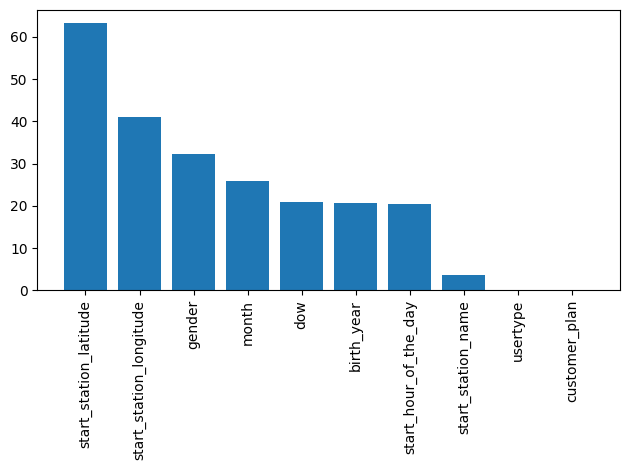

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(feature_names, shap_values):
 # Get the mean absolute contribution for each feature
 aggregate = np.mean(np.abs(shap_values[:, 0:-1]), axis=0)
 # sort by magnitude
 z = [(x, y) for y, x in sorted(zip(aggregate, feature_names), reverse=True)]
 z = list(zip(*z))
 plt.bar(z[0], z[1])
 plt.xticks(rotation=90)
 plt.tight_layout()
 plt.show()


plot_feature_importance(X_test.columns, shap_values)

This shows us that the most important features in predicting ride duration are the location of the pick up point.


We can also use SHAP to consider the importance of interactions between features. This is more computationally expensive again, but can bring valuable insights. The following cell will take around 100 seconds to run.

In [ ]:
%%time
shap_interactions = trained_model.predict(shap_sample, pred_interactions=True)

CPU times: user 2.14 s, sys: 11.1 ms, total: 2.15 s
Wall time: 2.15 s


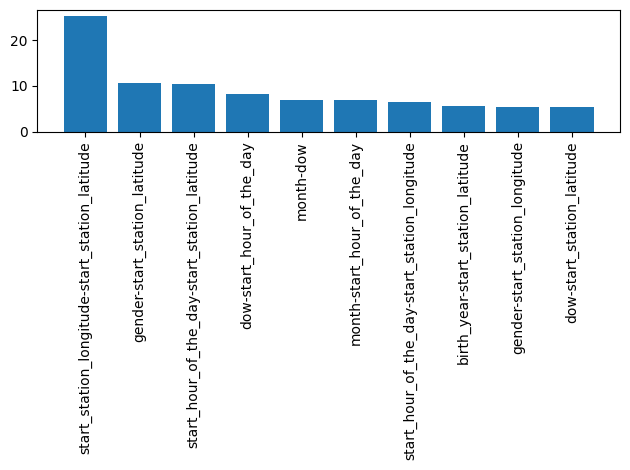

In [ ]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
 # Get the mean absolute contribution for each feature interaction
 aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
 interactions = []
 for i in range(aggregate_interactions.shape[0]):
     for j in range(aggregate_interactions.shape[1]):
         if j < i:
             interactions.append(
             (feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
 # sort by magnitude
 interactions.sort(key=lambda x: x[1], reverse=True)
 interaction_features, interaction_values = map(tuple, zip(*interactions))
 plt.bar(interaction_features[:k], interaction_values[:k])
 plt.xticks(rotation=90)
 plt.tight_layout()
 plt.show()


plot_top_k_interactions(X_test.columns, shap_interactions, 10)

Here we see (unsurprisingly) that the interactions between the starting longitude and latitude greatly influence the predictions, followed by a location and starting time of ride.

## Accelerating Inference

Throughout this notebook we have run most of our computation on the GPU. In this Section, we compare the speed it takes to make predictions on a CPU vs the GPU.

In [ ]:
xgb_features = xgb.DMatrix(X_test.astype("float32"))

### CPU

We first re-load the model from file, as XGBoost caches the results of previous predictions.

In [ ]:
%%time
model = xgb.Booster(model_file="xgb.model")
model.set_param({"predictor": "cpu_predictor"})
predictions = model.predict(xgb_features)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:22:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 30.2 s, sys: 60 ms, total: 30.2 s
Wall time: 20.3 s


### GPU

Now we can again reload the model, and this time run the same predictions on the GPU

In [ ]:
%%time
model = xgb.Booster(model_file="xgb.model")
model.set_param({"predictor": "gpu_predictor"})
predictions = model.predict(xgb_features)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:22:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 29.5 s, sys: 52.5 ms, total: 29.5 s
Wall time: 16.8 s


So you can see that the GPU allows us to make predictions in a fraction of the time taken on CPU. This is ideal for situations requiring real-time inference.

## Conclusion

In this notebook you've seen how we can use cuML, cuDF and XGBoost to explore and clean data, compute feature vectors and train a machine learning model to predict ride duration on the CitiBike Data Set.

To find out more, check out [RAPIDS.ai](http://rapids.ai).